In [ ]:
import os
import numpy as np # type: ignore
import pandas as pd # type: ignore
import tensorflow as tf # type: ignore
import json
import matplotlib.pyplot as plt # type: ignore
import seaborn as sns # type: ignore
from sklearn.metrics import roc_curve, auc # type: ignore
from sklearn.decomposition import PCA
from visualizations import *

/Users/bwelsh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data = []
with open('../json/reviews_Kindle_Store_5.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))


df = pd.DataFrame(data)
df = df[['reviewerID', 'asin', 'overall', 'unixReviewTime']]
df.dropna(inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder

user_enc = LabelEncoder()
item_enc = LabelEncoder()

clean_df = pd.DataFrame()

df['user'] = user_enc.fit_transform(df['reviewerID'])
df['item'] = item_enc.fit_transform(df['asin'])
df['rating'] = df['overall']


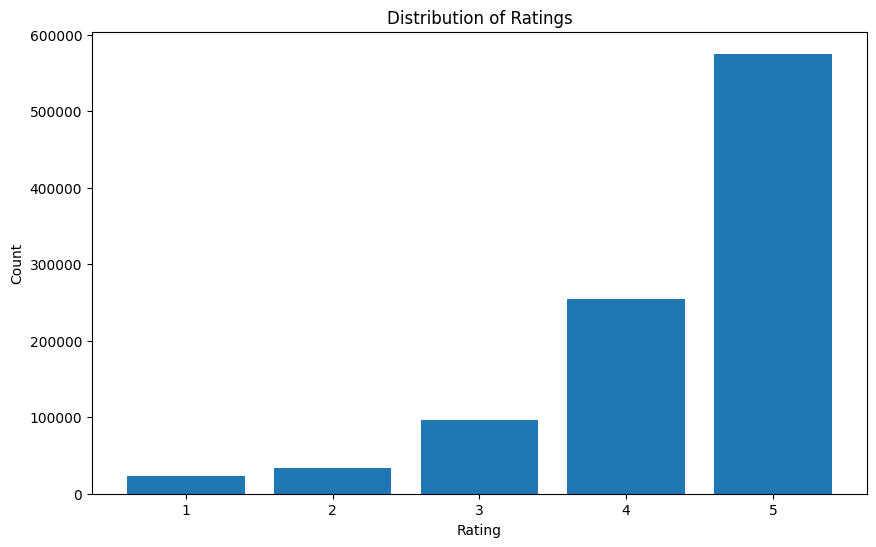

In [ ]:
plot_rating_distribution(df, "NCF_rating_distribution.png")

In [5]:
clean_df = df[['user', 'item', 'rating']][df['rating'] >= 3.0]
clean_df

,user,item,rating
0,7773,0,5.0
1,61894,0,4.0
2,53977,0,4.0
3,8128,0,5.0
4,50527,0,4.0
...,...,...,...
982614,35142,61933,5.0
982615,4097,61933,5.0
982616,18464,61933,5.0
982617,5981,61933,5.0


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim

In [7]:
class RatingDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        
        self.users = torch.tensor(df['user'].values, dtype=torch.long)
        self.items = torch.tensor(df['item'].values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float).view(-1, 1)
        # Normalize ratings for BCE loss
        self.ratings = (self.ratings - 1) / 4.0  # Assuming ratings are 1-5
        
    def __len__(self):
        return len(self.users)
        
    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]

In [8]:
class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dimension = 8, mlp_layers=[16,8], dropout=0.2):
        """ 
        num_users: number of users
        num_items: number of items
        embedding_dimension: dimension of the embeddings for the matrix factorization
        mlp_layers: sizes of hidden mulit-layer-perceptron
        """
        super(NCF, self).__init__()

        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(dropout)

        #Matrix factorization embeddings
        self.user_embeddings_mf = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mf = nn.Embedding(num_items, embedding_dimension)

        #multi-layer perceptron embeddings
        self.user_embeddings_mlp = nn.Embedding(num_users, embedding_dimension)
        self.item_embeddings_mlp = nn.Embedding(num_items, embedding_dimension)

        #MLP layers
        mlp_modules = []
        input_size = embedding_dimension * 2
        for layer_size in mlp_layers:
            mlp_modules.append(nn.Linear(input_size, layer_size))
            mlp_modules.append(nn.ReLU())
            input_size = layer_size
        
        self.mlp = nn.Sequential(*mlp_modules)

        predict_size = embedding_dimension + mlp_layers[-1]
        
        # Final prediction layer -> output single score
        self.final_layer = nn.Linear(predict_size, 1)

        # You can use a Sigmoid at the end if doing binary classification
        self.sigmoid = nn.Sigmoid()

    def forward(self, user_ids, item_ids):
        """
        user_ids: [batch_size]
        item_ids: [batch_size]
        returns: predicted score [batch_size, 1]
        """
        user_gmf = self.dropout(self.user_embeddings_mf(user_ids))
        item_gmf = self.dropout(self.item_embeddings_mf(item_ids))
        gmf_output = user_gmf * item_gmf
        
        user_mlp = self.dropout(self.user_embeddings_mlp(user_ids))
        item_mlp = self.dropout(self.item_embeddings_mlp(item_ids))
        mlp_input = torch.cat((user_mlp, item_mlp), dim=1)
        mlp_output = self.mlp(mlp_input)

        # 1) GMF part
        user_gmf = self.user_embeddings_mf(user_ids)        # [batch_size, embedding_dim]
        item_gmf = self.item_embeddings_mf(item_ids)        # [batch_size, embedding_dim]
        gmf_output = user_gmf * item_gmf                    # element-wise product [batch_size, embedding_dim]

        # 2) MLP part
        user_mlp = self.user_embeddings_mlp(user_ids)        # [batch_size, embedding_dim]
        item_mlp = self.item_embeddings_mlp(item_ids)        # [batch_size, embedding_dim]
        mlp_input = torch.cat((user_mlp, item_mlp), dim=1)  # [batch_size, embedding_dim*2]
        mlp_output = self.mlp(mlp_input)                    # [batch_size, mlp_layers[-1]]

        # 3) Concatenate GMF & MLP
        concat = torch.cat((gmf_output, mlp_output), dim=1) # [batch_size, embedding_dim + mlp_layers[-1]]

        # 4) Final layer
        logits = self.final_layer(concat)    # [batch_size, 1]
        preds = self.sigmoid(logits)         # apply sigmoid for probability

        return preds

In [9]:
def leave_one_out_split(df):
    # Sort by user and (optionally) timestamp or item if available
    df = df.sort_values(by=["user", "item"])  # if no timestamp

    test_rows = []
    train_rows = []

    # Leave the last interaction (or any 1) per user for test set
    for user, group in df.groupby("user"):
        test_rows.append(group.iloc[-1])      # Last rating to test
        train_rows.append(group.iloc[:-1])    # All others to train

    test_df = pd.DataFrame(test_rows)
    train_df = pd.concat(train_rows)

    return train_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [10]:
def train_test_split(df, test_size=0.2):
    # First split users
    unique_users = df['user'].unique()
    np.random.shuffle(unique_users)
    split_idx = int(len(unique_users) * (1 - test_size))
    train_users = unique_users[:split_idx]
    test_users = unique_users[split_idx:]
    
    # Split data based on users
    train_df = df[df['user'].isin(train_users)]
    test_df = df[df['user'].isin(test_users)]
    
    return train_df, test_df

In [11]:
train, test = leave_one_out_split(clean_df)

train_dataset = RatingDataset(train)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=128, shuffle=True)

test_dataset = RatingDataset(test)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=128, shuffle=False)

# Sample hyperparameters
num_users = clean_df['user'].max() + 1  # +1 because 0-indexed
num_items = clean_df['item'].max() + 1  # +1 because 0-indexed
embedding_dimension = 8

model = NCF(num_users, num_items, embedding_dimension=embedding_dimension, mlp_layers=[16, 8])
model.train()  # set to training mode

criterion = nn.BCELoss()  # for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

""" Plotting data structures """
# Plotting loss over time
running_loss = []

# Training loop (will overfit)
epochs = 20
for epoch in range(epochs):
    total_loss = 0.0
    for batch_users, batch_items, batch_ratings in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_users, batch_items)
        loss = criterion(predictions, batch_ratings)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_users.size(0)  # Weighted by batch size

    avg_loss = total_loss / len(train_dataset)

    # append the loss to the running_loss list
    running_loss.append(avg_loss)
    
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

Epoch 1/20, Loss: 0.3727
Epoch 2/20, Loss: 0.3456
Epoch 3/20, Loss: 0.3306
Epoch 4/20, Loss: 0.3207
Epoch 5/20, Loss: 0.3134
Epoch 6/20, Loss: 0.3074
Epoch 7/20, Loss: 0.3023
Epoch 8/20, Loss: 0.2974
Epoch 9/20, Loss: 0.2928
Epoch 10/20, Loss: 0.2885
Epoch 11/20, Loss: 0.2843
Epoch 12/20, Loss: 0.2804
Epoch 13/20, Loss: 0.2767
Epoch 14/20, Loss: 0.2731
Epoch 15/20, Loss: 0.2699
Epoch 16/20, Loss: 0.2668
Epoch 17/20, Loss: 0.2640
Epoch 18/20, Loss: 0.2614
Epoch 19/20, Loss: 0.2591
Epoch 20/20, Loss: 0.2569


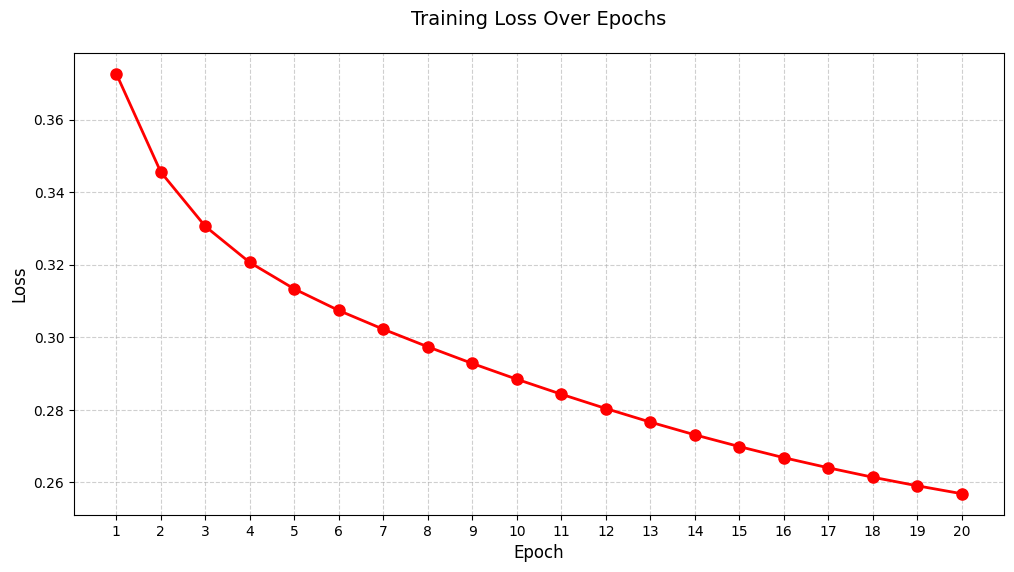

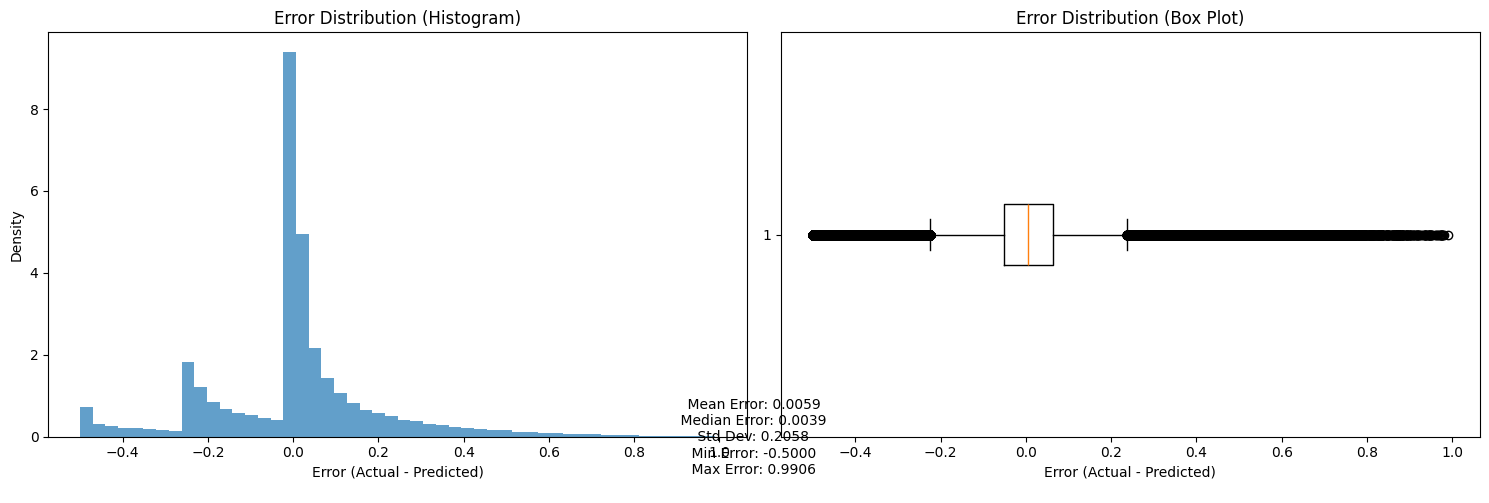

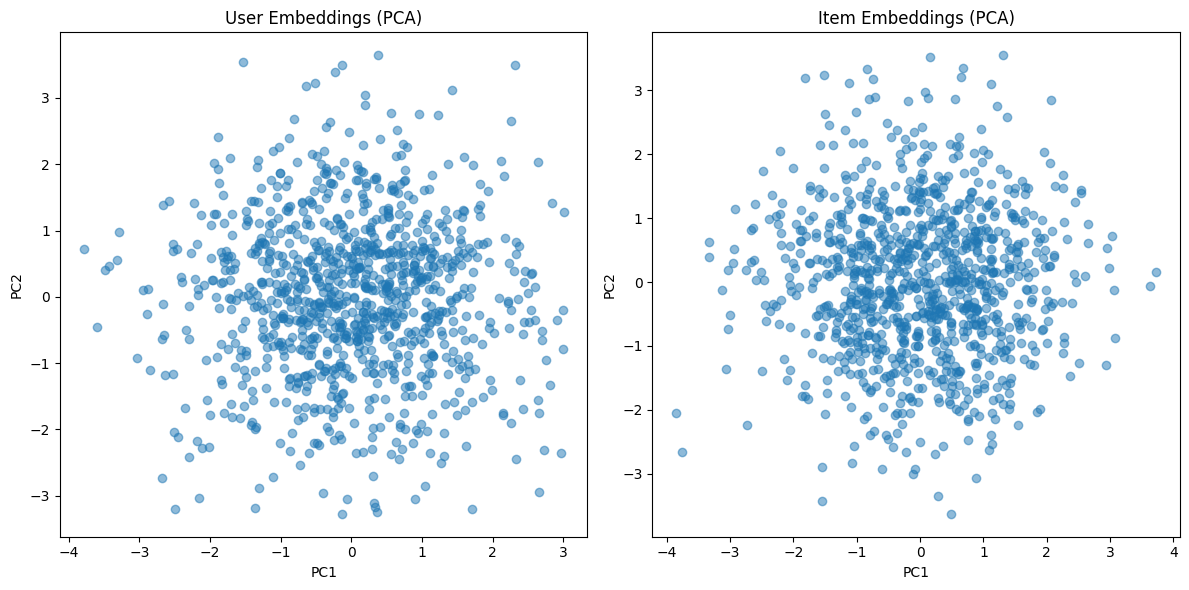

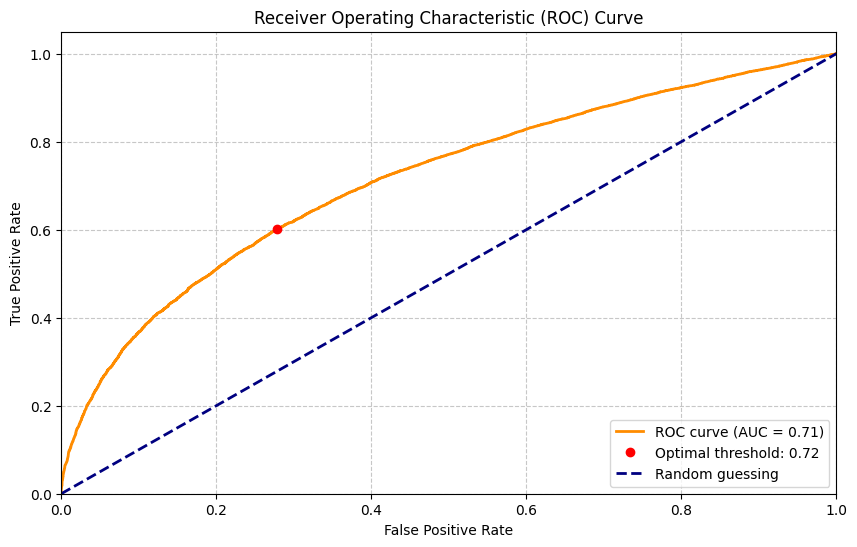

In [13]:
#use graph functions in visualizations.py
plot_training_history(running_loss, save_path="NCF_training_history1.png")

plot_error_distribution(model, test_loader, save_path="NCF_error_distribution1.png")

plot_embeddings(model, clean_df, save_path="NCF_embeddings1.png")

plot_roc_curve(model, test_loader, criterion, save_path="NCF_roc_curve1.png")

In [14]:
model.eval()
with torch.no_grad():
    test_loss = 0.0
    for batch_users, batch_items, batch_ratings in test_loader:
        predictions = model(batch_users, batch_items)
        test_loss += criterion(predictions, batch_ratings).item() * batch_users.size(0)
    
    avg_test_loss = test_loss / len(test_dataset)
    print(f"Test Loss: {avg_test_loss:.4f}")


Test Loss: 0.4232
